# Tutorial for Time-Domain Simulation

This notebook provides a tutorial on how to use the Time-Domain Simulation software. In its simplest form, the software takes a netlist of models, connections, and ports, and produces a `TimeResult` object containing the simulated outputs at each port in the system.

The simulation process is based on the S-parameters of the individual components, which are compiled into a single S-parameter matrix using SAX (Scattering And eXcitation) circuit formulations. Consequently, the netlist you supply follows the same format as a standard SAX netlist. Conceptually, an S-parameter matrix is synonymous with a transfer function that describes how input signals at one port propagate to the outputs at other ports across the frequency domain. Any model you provide must supply its S-parameter matrix. Conveniently, most commonly used photonic models (and their variations) are available in the SiEPIC Symphony library, where they can be adapted to meet specific requirements.

These S-parameters are then used to fit a pole-residue model, which can be solved analytically to obtain a state-space representation of the circuit. This representation encodes all the information needed for the time-stepping algorithm to update the circuit’s state at each simulation step and simultaneously produce the outputs, ultimately storing them in the `TimeResult` class.

Let’s begin by importing the required libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

from simphony.time_domain.simulation import TimeSim,TimeResult
from simphony.time_domain.utils import  gaussian_pulse, smooth_rectangular_pulse
from simphony.libraries import siepic
from simphony.time_domain.ideal import Modulator
import matplotlib

Now we define our netlist. A netlist contains the models and their instances, their interconnections, and the ports through which inputs and outputs are directed. It encapsulates the circuit information necessary for simulation. In our first example, we simulate a ring resonator as illustrated in the figure below.

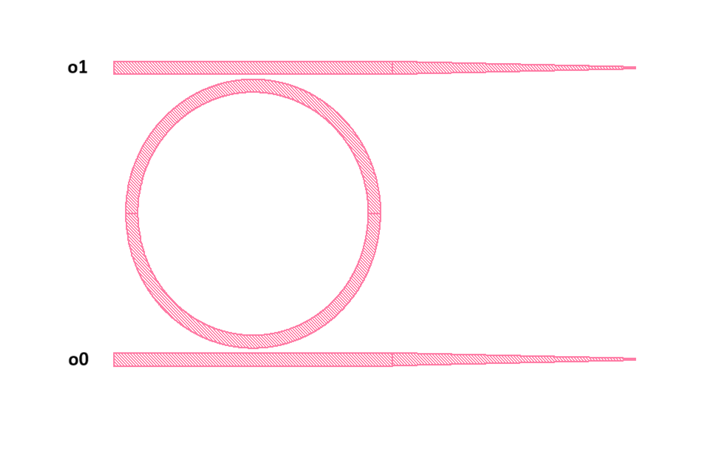

This design uses two half-ring components from the SiEPIC Symphony library, resulting in a total of four ports. Two of these ports are terminated with terminators, allowing us to focus on the behavior of the remaining two ports. The netlist is described as follows:


In [3]:
netlist = {
    "instances": {
        "hr1":"half_ring",
        "hr2":"half_ring",
        "t1": "terminator",
        "t2": "terminator",
    },
    "connections": {
        "hr1,port_1":"hr2,port_1",
        "hr1,port_3":"hr2,port_3",
        "hr1,port_4":"t1,port_1",
        "hr2,port_4":"t2,port_1",
    },
    "ports": {
        "o0": "hr1,port_2",
        "o1": "hr2,port_2",
    },
}

models = {
    "waveguide": siepic.waveguide,
    "half_ring": siepic.half_ring,
    "terminator": siepic.terminator,
}

As observed, the netlist delineates the interconnections between the various components and defines the ports. The "instances" represent the individual occurrences of the models, as specified in the models section.

With the netlist defined, we can now create the `TimeSim` object. This object encapsulates all the necessary information required to perform the simulation. In the next step, we pass in our netlist and the models.


In [4]:
time_sim = TimeSim(netlist=netlist, models=models)

The `time_sim` object contains three essential functions for constructing the time-domain model. The first function handles instantiation, where the user provides the netlist and the associated models. The second and third functions are part of the `build_model` method. This method supplies the algorithm with all necessary information, allowing the user to adjust model parameters, specify the frequency range (using a range of wavelengths), set the time steps, and more. Detailed documentation is available for all parameters that can be modified.

For simplicity, we outline the configuration for our models. The available options follow the conventions defined by SAX circuits, as these options will be passed directly into the SAX circuit module during modeling. 

Now, let's define the lengths of our waveguides and the frequency spectrum.


In [18]:
options = {
    'wl': np.linspace(1.5, 1.6, 200),
    'wg': {"length": 10.0, "loss": 100},
}
time_sim.build_model(model_parameters=options)

Now we define our inputs. Since our system has two ports, we need to specify input signals for each one. We also define the time range for the simulation in the time domain. This information will be passed to our `run` method.

The `run` method accepts two parameters:
- A time array.
- A dictionary of inputs, where the keys correspond to the system's ports and the values are the input arrays (each having the same number of time steps as the time array).

When executed, the `run` method returns a `TimeResult` object containing:
- The input dictionary.
- The output dictionary.
- The S-parameters.
- The time array.

Additionally, the `TimeResult` `Data` class provides methods to plot the outputs alongside the inputs. In this example, we apply a constant input to our ring resonator at port `o0` (as illustrated in the diagram above).


In [ ]:
T = 8.0e-11      
dt = 1e-14       
t = jnp.arange(0, T, dt)

inputs = {
            f'o{i}': smooth_rectangular_pulse(t,0.0e-11,5.0e-11) if i == 0 else jnp.zeros_like(t)
            for i in range(2)
        }
modelResult =time_sim.run(t, inputs)

We will now plot the results

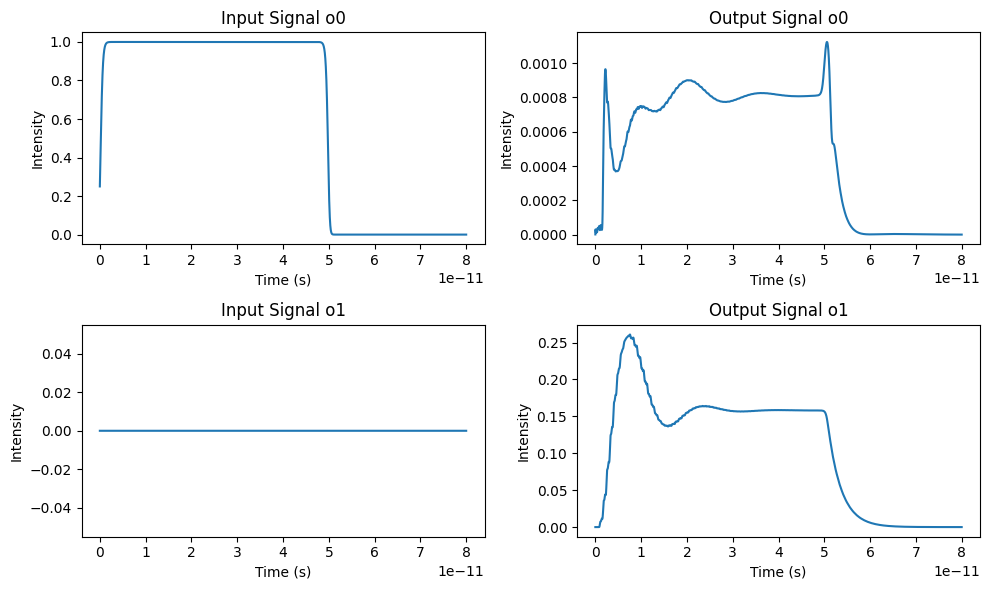

In [20]:
modelResult.plot_sim()

The input signal is active for 5e-11 seconds before being turned off. The ring resonator responds by initially rising in intensity and then settling to a steady-state value. The multiple bumps observed in the output correspond to the light circulating around the ring resonator, with each bump representing another pass through the ring. Once the input signal is turned off, the output eventually decays back to zero.


Unfortunately, the pole-residue model is inherently limited to simulating time-invariant (passive) components. However, active components can be incorporated into the simulation with a few modifications:

1. **Identify Active Components:**  
   The user must explicitly specify which instances in the circuit are active by including them in an `active_component` list.

2. **Define the Active Component Model:**  
   For each active component, the user must create a model that implements a `response` function. This function should accept an input dictionary (with keys corresponding to the component's ports) and return an output dictionary with the same structure.

For example, here is a simple implementation of a phase modulator's response function:

```python
def response(self, inputs: dict) -> dict:
    N = inputs['o0'].shape[0]
    o0_response = jnp.zeros((N), dtype=complex)
    o1_response = jnp.zeros((N), dtype=complex)
    
    for i in range(N):
        o0_response = o0_response.at[i].set(inputs['o1'][i] * self.s_mod[self.countstep])
        o1_response = o1_response.at[i].set(inputs['o0'][i] * self.s_mod[self.countstep])
    
    self.countstep += 1
    
    response = {
        "o0": o0_response,
        "o1": o1_response,
    }
    
    return response


With the response function in place, the algorithm is able to simulate active components alongside passive components as it steps through time. To enable this, the user simply needs to define an `active_component` list and include their corresponding models in the overall model list, as illustrated below:

In [24]:
from simphony.time_domain.ideal import Modulator
T = 2.5e-11
dt = 1e-14     
t = jnp.arange(0, T, dt)

mu = 1.30 
sigma = 0.15     
x = jnp.linspace(0, 3.14, len(t))

gaussian = np.pi*jnp.exp(-0.5*((x - mu) / sigma) ** 2)
timePhaseInstantiated = Modulator(mod_signal=gaussian)

netlist={
    "instances": {
        "wg": "waveguide",
        "y": "y_branch",
        "pm": "phase_modulator",
        "wg2": "waveguide",
        "y2": "y_branch",
    },
    "connections": {
        "y,port_2":"wg,o0",
        "y,port_3":"wg2,o0",
        "wg,o1":"pm,o0",
        "y2,port_2":"wg2,o1",
        "y2,port_3":"pm,o1",

    },
    "ports": {
        "o0":"y,port_1",
        "o1":"y2,port_1",

    },
}
models={
    "waveguide": siepic.waveguide,
    "y_branch": siepic.y_branch,
    "bidirectional": siepic.bidirectional_coupler,
    "phase_modulator": timePhaseInstantiated,
    
}
active_components = {
    "pm","pm2"
}

In this example, we demonstrate how the active/passive time-domain simulation works. First, we use a phase modulator to introduce a phase shift in the signal passing through it. The phase modulator is driven by an input signal—in this case, a Gaussian pulse that induces a phase shift of π at its peak.

This phase modulator is then integrated into a Mach-Zehnder Interferometer (MZI) configuration, as illustrated below. The MZI splits the signal into two paths, with one arm receiving the phase-shifted signal while the other remains unchanged. When the two signals are recombined, the interference between them produces a temporal dip in the output signal due to the phase difference.


<img src="MZI.png" style=" width: 300px;" alt="MZI">




--- Passive Sub-Netlist 0 ---

Instances: {'wg': 'waveguide', 'y': 'y_branch', 'y2': 'y_branch', 'wg2': 'waveguide'}

Connections: {'y,port_2': 'wg,o0', 'y,port_3': 'wg2,o0', 'y2,port_2': 'wg2,o1'}

Ports: {'o0': 'y,port_1', 'o1': 'y2,port_1', 'o2': 'wg,o1', 'o3': 'y2,port_3'}


--- Final Time-Domain Netlist ---

Models: {'pm': <simphony.time_domain.ideal.Modulator object at 0x7f98b537ce10>, '0': <simphony.time_domain.time_system.TimeSystemIIR object at 0x7f98b63ae410>}

Connections: {'0,o2': 'pm,o0', '0,o3': 'pm,o1'}

Ports: {'o0': '0,o0', 'o1': '0,o1'}



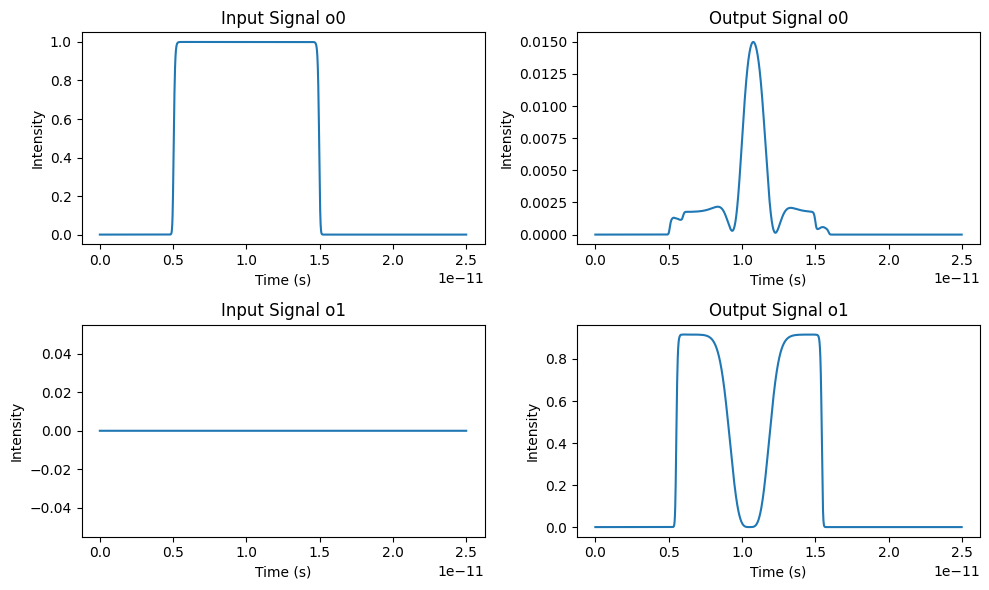

In [25]:
num_measurements = 200
model_order = 50
center_wvl = 1.548
wvl = np.linspace(1.5, 1.6, num_measurements)
time_sim = TimeSim(
    netlist=netlist,
    models=models,
    active_components=active_components,
    )


options = {'wl':wvl,'wg':{"length": 10.0, "loss": 100}, 'wg2':{"length": 10.0, "loss": 100}}
time_sim.build_model(model_parameters=options)

inputs = {
            f'o{i}': smooth_rectangular_pulse(t,0.5e-11,1.5e-11) if i == 0 else jnp.zeros_like(t)
            for i in range(2)
        }

modelResult =time_sim.run(t, inputs)

modelResult.plot_sim()

With active components in the circuit, the simulation algorithm produces both subnetlists and a final netlist. To integrate active components with passive ones, the algorithm first separates the passive components from the active components. The passive components are then organized into subnetlists and simulated using the pole-residue model. After simulation, these results are reintegrated with the active components for further processing by the algorithm. The netlists are returned to the user for debugging purposes.

Reviewing the simulation results, we observe the expected dip in the signal caused by the Gaussian pulse in the phase modulator—the signal drops to zero before returning to its original level. Additionally, the results clearly show a time delay and loss as the signal travels through the Mach-Zehnder Interferometer (MZI), with the intensity decreasing to approximately 0.8.


Finally we have a a slightly more complicated example to show how robust the model is in simluating photonic circuits.